Data cleaning and preparation

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#read the csv containing sales information for each year
#this data contain sensitive information and therefore are not available
s_18 = pd.read_csv('sales_2018.csv', sep=";")
s_19 = pd.read_csv('sales_2019.csv', sep=";")
s_20 = pd.read_csv('sales_2020.csv', sep=";")
s_21 = pd.read_csv('sales_2021.csv', sep=";")
s_22 = pd.read_csv('sales_2022.csv', sep=";")

In [105]:
#checking the dataframes 
s_18.columns
s_22[['order_id', 'order_date', 'qty', 'individual_price', 'order_total']].head()

,order_id,order_date,qty,individual_price,order_total
0,77127,2021-11-08 08:59:35+00:00,48,53,"2667,95"
1,77128,2021-11-08 09:00:41+00:00,16,53,"888,19"
2,77129,2021-11-08 09:00:47+00:00,48,53,"2751,99"
3,77130,2021-11-08 09:00:54+00:00,48,53,"2667,95"
4,77131,2021-11-08 09:00:56+00:00,48,53,"2667,95"


In [5]:
# function to use within the next

def mkdf_timefreq(dist_sales, ind_sales, tfreq):
    '''groups and sums the distributors and individual sales based on a given time variable of the data set 
    and creates two different DFs under these time frequencies, both detailing distributors, individual and 
    total sales quantity. 
    
    dist_sales - df with distributors sales information
    ind_sales - df with individual sales information
    tfreq - df date column name'''
    
    #soma a quantidade de venda de cada grupo por dia
    qdist = dist_sales.groupby([tfreq])['qty'].sum()
    qind = ind_sales.groupby([tfreq])['qty'].sum()
    #cria frame de cada grupo com novo index
    df_dist = qdist.to_frame(name='qdist').reset_index()
    df_ind = qind.to_frame(name='qind').reset_index()
    
    #funde ambos frames pela data
    s_tf = pd.merge(df_ind, df_dist, how='outer', on=tfreq)
    s_tf = s_tf.sort_values(by=tfreq)
    #completa espaços em branco com 0
    s_tf = s_tf.fillna(0)
    #cria a variavel da quantidade total pela soma das quantidades de cada grupo
    s_tf['qtotal'] = s_tf['qind'] + s_tf['qdist']
    
    return s_tf

In [58]:
#this function selects the information we need from all the sales dfs

def select_transform(df):
    '''convert dates into datetime format, split the sales between those for distributors and those for 
    final custumers and call the first function to sum the quantities of each client type on daily and monthly
    basis'''

    #transform variable 'order_date' in 'date' on datetime format
    df['order_date'] = pd.to_datetime(df['order_date'], utc=True)
    df['date'] = pd.to_datetime(df['order_date'].dt.date)
    #organize by date
    df = df.sort_values(by='date')
    #extract month from date
    df['month'] = df['date'].astype('datetime64[M]')
    
    #split between sales for distributors and for individuals
    dist = df[df['individual_price'] < 60]
    ind = df[df['individual_price'] > 60]
    
    #call the function that will sum and create the dfs
    sales_day = mkdf_timefreq(dist, ind, 'date')
    sales_month = mkdf_timefreq(dist, ind, 'month')
      
    return sales_day, sales_month

In [59]:
#list the dfs
data_list = [s_18, s_19, s_20, s_21, s_22]

#iterate through dfs to append all years
sales_day = pd.DataFrame()
sales_month = pd.DataFrame()

for i in data_list:
    s_day, s_month = select_transform(i)
    sales_day = sales_day.append(s_day, ignore_index=True)
    sales_month = sales_month.append(s_month, ignore_index = True)

In [60]:
#visualizing the result 
sales_day.tail(10)

,date,qind,qdist,qtotal
604,2022-06-10,0.0,60.0,60.0
605,2022-06-11,0.0,17.0,17.0
606,2022-06-12,0.0,10.0,10.0
607,2022-06-13,0.0,20.0,20.0
608,2022-06-14,0.0,37.0,37.0
609,2022-06-15,0.0,18.0,18.0
610,2022-06-16,0.0,20.0,20.0
611,2022-06-17,0.0,28.0,28.0
612,2022-06-18,0.0,25.0,25.0
613,2022-06-19,0.0,27.0,27.0


In [17]:
#visualizing the result 
sales_month.tail(10)

,month,qind,qdist,qtotal
19,2021-01-01,1062.0,464.0,1526.0
20,2021-02-01,0.0,32.0,32.0
21,2021-11-01,7548.0,34992.0,42540.0
22,2021-12-01,6558.0,1456.0,8014.0
23,2022-01-01,4060.0,96.0,4156.0
24,2022-02-01,1148.0,112.0,1260.0
25,2022-03-01,680.0,0.0,680.0
26,2022-04-01,353.0,0.0,353.0
27,2022-05-01,319.0,383.0,702.0
28,2022-06-01,0.0,564.0,564.0


In [61]:
#fill missing dates with zero sales on daily df
idx = pd.date_range('2017-07-01', '2022-06-30')
sales_day = sales_day.set_index(['date'])
sales_day = sales_day.reindex(idx, fill_value=0).reset_index()
sales_day = sales_day.rename(columns={'index': 'date'})

In [96]:
#checking results
sales_day.iloc[1235:1245,]

,date,qind,qdist,qtotal
1235,2020-11-17,0.0,0.0,0.0
1236,2020-11-18,0.0,0.0,0.0
1237,2020-11-19,0.0,0.0,0.0
1238,2020-11-20,0.0,0.0,0.0
1239,2020-11-21,0.0,0.0,0.0
1240,2020-11-22,6564.0,13696.0,20260.0
1241,2020-11-23,1394.0,2064.0,3458.0
1242,2020-11-24,1326.0,0.0,1326.0
1243,2020-11-25,18.0,0.0,18.0
1244,2020-11-26,0.0,976.0,976.0


In [72]:
#fill missing months with zero sales
idx = pd.date_range('2017-07-01', '2022-06-01')
df = pd.DataFrame({'date': idx})
df['date'] = pd.to_datetime(df['date'].dt.date)
df['month'] = df['date'].astype('datetime64[M]')
df.drop('date', inplace=True, axis=1)

month = df.groupby(['month']).sum()
month = month.reset_index().replace(0, np.nan)

comp_sales_month = pd.merge_ordered(month, sales_month, on='month').fillna(0)
#vendas_mes_comp.to_csv('vendas_mes_comp.csv', index=False)

In [95]:
#checking monthly sales df
comp_sales_month.tail(15)

,month,qind,qdist,qtotal
45,2021-04-01,0.0,0.0,0.0
46,2021-05-01,0.0,0.0,0.0
47,2021-06-01,0.0,0.0,0.0
48,2021-07-01,0.0,0.0,0.0
49,2021-08-01,0.0,0.0,0.0
50,2021-09-01,0.0,0.0,0.0
51,2021-10-01,0.0,0.0,0.0
52,2021-11-01,7548.0,34992.0,42540.0
53,2021-12-01,6558.0,1456.0,8014.0
54,2022-01-01,4060.0,96.0,4156.0


<AxesSubplot:title={'center':'Vendas por dia'}, xlabel='date'>

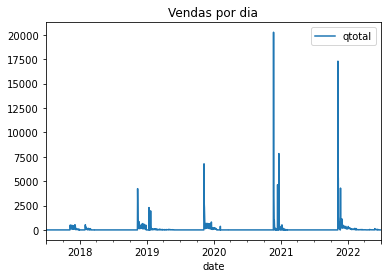

In [74]:
#a first vision of the daily sales
sales_day.plot(x='date', y='qtotal', title='Vendas por dia')

<AxesSubplot:title={'center':'Vendas por mes'}, xlabel='month', ylabel='qtotal'>

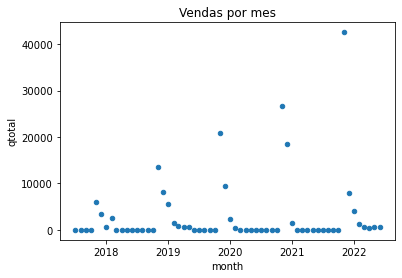

In [78]:
#a first vision of monthly sales
comp_sales_month.plot.scatter(x='month', y='qtotal', title='Vendas por mes')

In [80]:
#setting index to plot the data
sd = sales_day.set_index(['date'])
sm = comp_sales_month.set_index(['month'])

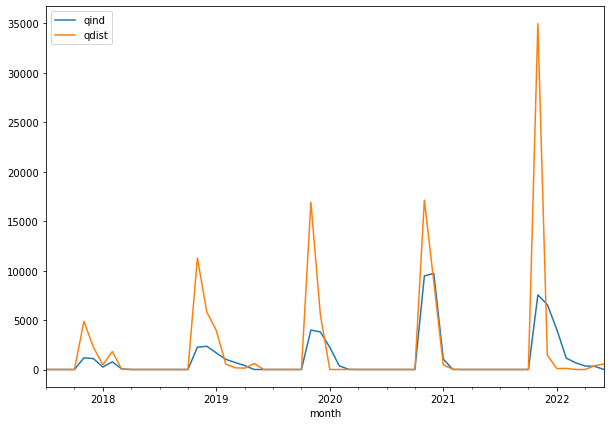

In [94]:
#plot monthly sales to distributors and final custumers
sm[['qind', 'qdist']].plot(figsize=(10, 7))
plt.show()

In [97]:
#salva csv
sales_day.to_csv('vendas_por_dia.csv', index=False)
comp_sales_month.to_csv('vendas_por_mes.csv', index=False)